# 预处理

在预处理数据之前，先对spaceship_titanic_exploration.ipynb数据探索作简单整理
## 已知
* PassengerId/HomePlanet/Cabin/Destination/Name

        PassengerId是顾客的标识符，由(组_组内号)表示，同一组的乘客一般为一家人；HomePlanet是家乡；Cabin是deck/num/side，处理方法需要参考；Destination是目的地，一家人、一组人的目的地是否一致？；Name是乘客姓名，对分类意义不大
* Age

        Age是乘客的年龄，是纯数值，不天生具有正态分布
* CryoSleep/VIP

        CryoSleep-是否睡在冷冻仓，是bool值，经过观察，在不在冷冻都有概率传送走；VIP-是否为会员，是bool值，VIP数量很少
* RoomService/FoodCourt/ShoppingMall/Spa/VRDeck

        开销，开销的呈现形式非常零散，而开销总和是应该被计算的
* 总结


        在两份数据集的完整度上，由于PassengerId是完整的，因此在缺失值填充的过程中应该优先考虑组，

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = "D:/temp_files/datasets/spaceship_titanic/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
train = train.drop(axis=1, labels='Name')
test = test.drop(axis=1, labels='Name')

## 缺失值填充

HomePlanet/Destination一律用

In [2]:
print(train.HomePlanet.value_counts())
print(train.Destination.value_counts())

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


In [3]:
train.HomePlanet.fillna(value='Earth', inplace=True)
train.Destination.fillna(value='TRAPPIST-1e', inplace=True)
test.HomePlanet.fillna(value='Earth', inplace=True)
test.Destination.fillna(value='TRAPPIST-1e', inplace=True)
def dest(row):
    if row == 'TRAPPIST-1e':
        return 'T'
    elif row == '55 Cancri e':
        return 'C'
    else:
        return 'P'
train.Destination = train.Destination.apply(dest)
test.Destination = test.Destination.apply(dest)

In [4]:
train.Age.fillna(value=train.Age.mean(), inplace=True)
test.Age.fillna(value=test.Age.mean(), inplace=True)
train['Total'] = 0
test['Total'] = 0
services = "RoomService/FoodCourt/ShoppingMall/Spa/VRDeck".split("/")
for service in services:
    train[service].fillna(value=train[service].mean(), inplace=True)
    test[service].fillna(value=test[service].mean(), inplace=True)
    train['Total'] = train['Total'] + train[service]
    test['Total'] = test['Total'] + test[service]
train.Total = train.Total.apply(lambda x : round(x))
test.Total = test.Total.apply(lambda x : round(x))

In [5]:
print(train.CryoSleep.value_counts())
print(train.VIP.value_counts())
print(test.CryoSleep.value_counts())
print(test.VIP.value_counts())

False    5439
True     3037
Name: CryoSleep, dtype: int64
False    8291
True      199
Name: VIP, dtype: int64
False    2640
True     1544
Name: CryoSleep, dtype: int64
False    4110
True       74
Name: VIP, dtype: int64


In [6]:
train.VIP.fillna(value=False, inplace=True)
train.CryoSleep.fillna(value=False, inplace=True)
test.VIP.fillna(value=False, inplace=True)
test.CryoSleep.fillna(value=False, inplace=True)

In [7]:
def break_down_passengerId(df):
    df['group_id'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    
    return df
train = break_down_passengerId(train)
test = break_down_passengerId(test)

In [8]:
def Cabin_Column(df):
    df['Cabin'] = df['Cabin'].fillna(df['Cabin'].mode()[0])  
    
    df['deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
    df['side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    return df
train = Cabin_Column(train)
test = Cabin_Column(test)


In [9]:
train.drop(labels=['PassengerId','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin'], inplace=True, axis=1)
test.drop(labels=['PassengerId','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin'], inplace=True, axis=1)

In [10]:
def featureCreation(df):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['deck'] = le.fit_transform(df['deck'])
    df['num'] = le.fit_transform(df['num'])
    df['side'] = le.fit_transform(df['side'])

    
    return df

train = featureCreation(train)
test  = featureCreation(test)

In [11]:
cols = ['HomePlanet','Destination','VIP','CryoSleep']
def Encoding(df,cols):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for c in cols:
        df[c] = le.fit_transform(df[c])
    return df

train = Encoding(train,cols)
test = Encoding(test,cols)

In [12]:
def check_family_members(df):
    df['No_of_family_members'] = df['group_id'].map(df['group_id'].value_counts())
    return df
train = check_family_members(train)
test = check_family_members(test)

In [13]:
def Age(df):
    df['Youth'] = df['Age'].apply(lambda x: 1 if x>0 and x<=18 else 0)
    df['Adult'] = df['Age'].apply(lambda x: 1 if x>18 else 0)
    
    return df

train = Age(train)
test = Age(test)

In [14]:
for col in train.columns:
    if train[col].dtype == bool:
        train[col]=train[col].astype('int')
for col in test.columns:
    if test[col].dtype == bool:
        test[col]=test[col].astype('int')

In [15]:
train.drop(axis=1,labels=['group_id', 'Age'], inplace=True)
test.drop(axis=1,labels=['group_id', 'Age'], inplace=True)

<AxesSubplot:xlabel='No_of_family_members', ylabel='count'>

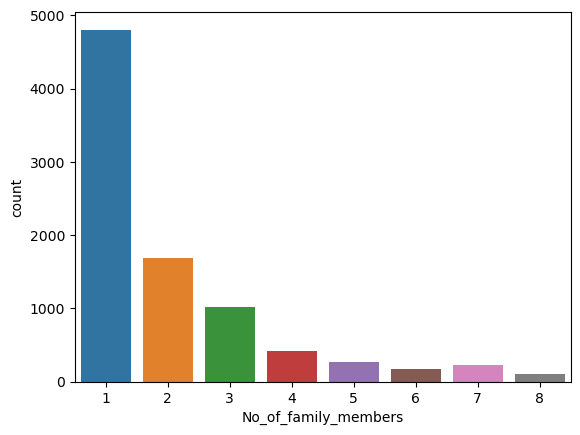

In [19]:
sns.countplot(data=train, x='No_of_family_members')

<AxesSubplot:xlabel='Adult', ylabel='count'>

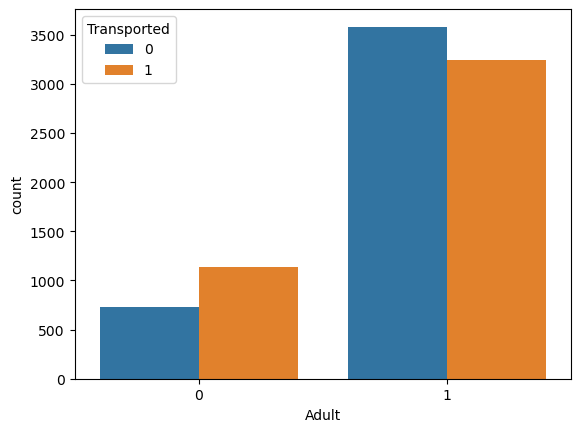

In [23]:
sns.countplot(data=train, x='Adult',hue='Transported')

In [16]:
def Scaling(df,name):
    from sklearn.preprocessing import StandardScaler
    if name == 'train':
        t_data = df.copy().drop('Transported',axis=1)
        ss = StandardScaler()
        ss.fit(t_data)
        dff = pd.DataFrame(ss.transform(t_data),index=t_data.index,columns=t_data.columns)
        dff['Transported'] = df['Transported']
    
    else:
        ss = StandardScaler()
        ss.fit(df)
        dff = pd.DataFrame(ss.transform(df),index=df.index,columns=df.columns)
        
    return dff

train = Scaling(train,'train')
test = Scaling(test,'test')

In [17]:
train.to_csv(path + "train_full.csv", index=False)
test.to_csv(path + "test_full.csv", index=False)